# Dependencies

In [67]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

In [65]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [57]:
import matplotlib.pyplot as plt

SMALL_SIZE = 12
MEDIUM_SIZE = 16
BIGGER_SIZE = 30

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE, figsize=(15,8))  # fontsize of the figure title

# IPF Demo

## Setup

First we'll generate some data, and for any data that is lower than some minimum threshold, we'll replace it with a random seed:

In [109]:
RANGE = (1, 10)
MIN_VALUE = 3
SIZE = (5,5)

# Generate some original data
original_data = np.rint(np.random.uniform(low=RANGE[0], high=RANGE[1], size=SIZE))

# Any value less than MIN_VALUE is going to be suppressed.
missing_value_mask = original_data < MIN_VALUE
missing_values = original_data[missing_value_mask]

# Calculate the totals before we suppress.
column_totals = np.sum(original_data, axis=0)
row_totals = np.sum(original_data, axis=1)



# Replace the suppressed numbers with a random number in the interval [0, MIN_VALUE]
suppressed_data = np.copy(original_data)
suppressed_data[missing_value_mask] = np.rint(np.random.uniform(low=1, high=MIN_VALUE, size=missing_values.shape))

In [110]:
print(original_data)
print(missing_values)
print(missing_value_mask)
print(suppressed_data)
print(row_totals)
print(column_totals)

[[ 10.  10.   2.   8.   2.]
 [  7.   3.   4.   8.   5.]
 [  8.   6.   3.   1.   3.]
 [  7.   4.   3.   4.   6.]
 [  9.   1.   9.   9.   7.]]
[ 2.  2.  1.  1.]
[[False False  True False  True]
 [False False False False False]
 [False False False  True False]
 [False False False False False]
 [False  True False False False]]
[[ 10.  10.   2.   8.   1.]
 [  7.   3.   4.   8.   5.]
 [  8.   6.   3.   2.   3.]
 [  7.   4.   3.   4.   6.]
 [  9.   3.   9.   9.   7.]]
[ 32.  27.  21.  24.  35.]
[ 41.  24.  21.  30.  23.]


In [98]:
print(np.sum(original_data[0, :]))
print(row_totals[0])

28.0
28.0


Let's take a look at how far off our random seeds are:

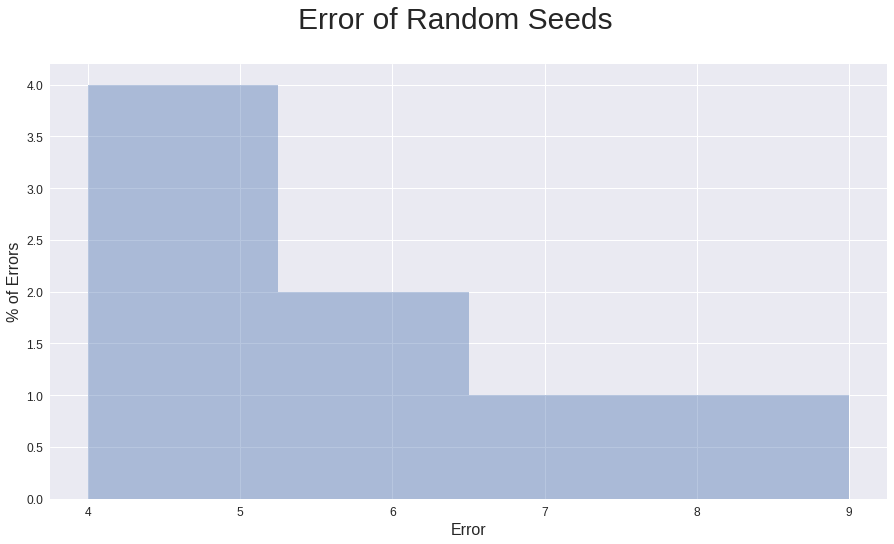

In [66]:
errors = np.absolute(suppressed_data[missing_value_mask] - missing_values)
sns.distplot(errors, kde=False)
plt.suptitle("Error of Random Seeds")
plt.ylabel("% of Errors")
plt.xlabel("Error")
plt.show()

In [68]:
stats.describe(errors)

DescribeResult(nobs=8, minmax=(4.0, 9.0), mean=5.75, variance=2.7857142857142856, skewness=0.8129583193181347, kurtosis=-0.193293885601578)

## IPF

In [229]:
CONVERGENCE_THRESHOLD = 1e-5
MAX_ITERATIONS = 1000

#while np.sum(errors) > CONVERGENCE_THRESHOLD:

# Process rows
current_row_totals = np.sum(suppressed_data, axis=1)
current_column_totals = np.sum(suppressed_data, axis=0)
    
print(suppressed_data)
for row in range(SIZE[0]):
    missing_indexes = missing_value_mask[row, :]    
    suppressed_data[row, missing_indexes] = suppressed_data[row, missing_indexes] / current_row_totals[row] 
    suppressed_data[row, missing_indexes] = suppressed_data[row, missing_indexes] * row_totals[row]
    
for col in range(SIZE[1]):
    missing_indexes = missing_value_mask[:, col]    
    suppressed_data[missing_indexes, col] = suppressed_data[missing_indexes, col] / current_column_totals[col] 
    suppressed_data[missing_indexes, col] = suppressed_data[missing_indexes, col] * column_totals[col]    
    
print(original_data[missing_value_mask])
print(suppressed_data[missing_value_mask])    

[[ 10.          10.           2.00003615   8.           1.99996138]
 [  7.           3.           4.           8.           5.        ]
 [  8.           6.           3.           1.00003862   3.        ]
 [  7.           4.           3.           4.           6.        ]
 [  9.           1.00022581   9.           9.           7.        ]]
[ 2.  2.  1.  1.]
[ 2.00003286  1.99996489  1.00003549  1.00020994]


In [75]:
original_data[0,[True, False, False, False, False, False, False, False]]

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 1; dimension is 10 but corresponding boolean dimension is 8
  """Entry point for launching an IPython kernel.


array([ 12.])